In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import  torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
import sys
import seaborn as sns
sys.path.append('/home/aggelos/PersonalProjects/ForecastingLib/')
from tsutils import SequenceSpliter
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [67]:
class TimeSeriesDataSet(Dataset):

    def __init__(self, datafile, features, lookback, feature_to_reconstruct):
        self.features = features
        self.feature_to_reconstruct = feature_to_reconstruct
        self.lookback = lookback

        df = pd.read_csv(datafile, usecols=self.features, delimiter='\t')
        df = df.rolling(lookback).mean().dropna()
        spliter = SequenceSpliter(lookback, 1)
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df)
        df.iloc[:, :] = scaled
        X, _ = spliter.fit_transform(df.values)
        X = np.swapaxes(X, 1,2)
        self.target_idx = df.columns.get_loc(self.feature_to_reconstruct)
        self.dataset = torch.Tensor(X)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        return torch.Tensor(self.dataset[item])


workers = 4

batch_size = 128

lookback = 128



features = ['voltage [V]',
            'acceleration (actual) [m/(s*s)]',
            'tractive effort (actual) [kN]',
            'track-earth voltage [V]',
            'speed (actual) [km/h]',
            'current [A]',
            'energy balance [kWh]',
            'way (actual) [km]',
            'line and running resistance [kN]',
            'train configuration [1]',
            'energy input [kWh]',
            'train configuration [1]',
            'usable braking energy [kWh]',
            'used braking energy [kWh]'
            ]

nb_features = len(features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33NO/7hnz0038.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)

validation_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33NO/7hnz0040.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)


In [68]:
class Encoder(nn.Module):
    """This is the encoder part of the autoencoder"""
    
    def __init__(self, lookback):
        super().__init__()
        self.lookback = lookback
        self.dilations = [2**i for i in range(1,int(np.log2(lookback/2)))]
        self.conv1 = nn.Conv1d(13, self.lookback, kernel_size=3, stride=1, padding=1)
        self.layers = nn.ModuleList([])
        i=2
        for dilation in self.dilations:
            self.layers.append(nn.Conv1d(self.lookback//(i//2), self.lookback//i, kernel_size=3, stride=2, dilation=dilation, padding=dilation))
            i *= 2
        self.activation = nn.ReLU()
        self.mean = nn.Linear(16, 16)
        self.std = nn.Linear(16, 16)

    
    def forward(self, x):
        x = self.activation(self.conv1(x))
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2])
        

        return self.mean(x), self.std(x)
        

In [69]:
class Decoder(nn.Module):
    def __init__(self, lookback):
        """The decoder part of the autoencoder """
        
        super().__init__()
        self.layers = nn.ModuleList([])
        in_channels = 0
        i=1
        while in_channels != lookback//2:
            in_channels = i*4
            self.layers.append(nn.ConvTranspose1d(in_channels, 2*in_channels,kernel_size=in_channels, stride=1))
            i *= 2
        self.conv6 = nn.ConvTranspose1d(lookback, 13, 8, stride=1, padding=1)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        x = x.view(x.shape[0],4,4)
        for layer in self.layers:
            x = self.activation(layer(x))
        x = torch.sigmoid(self.conv6(x))
        return x

In [70]:
class AE(nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.encoder = Encoder(lookback)
        self.decoder = Decoder(lookback)
    def forward(self, x):
        mean, std = self.encoder(x)
        std = torch.exp(0.5*std)
        eps = torch.rand_like(std)
        z = eps.mul(std).add_(mean)
        reconstructed = self.decoder(z)
        return reconstructed, mean, std

In [80]:
def loss(original, reconstructed, mu, log_var):
    CE = F.mse_loss(reconstructed, original)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return KLD + CE

In [81]:
ae = AE(lookback).to(device)
optimizer = optim.Adam(ae.parameters())
history_train_loss = []
history_val_loss = []
dataloaders = {'train': train_dataloader,
              'validation': validation_dataloader}

In [82]:
for epoch in tqdm(range(10)):
    train_loss = 0
    for mode, dataloader in dataloaders.items():
        for batch in dataloader:
                if mode == 'train':
                    ae.train()
                    optimizer.zero_grad()
                    reconstructed, output_mean, output_std = ae(batch)
                    train_loss += loss(batch, reconstructed, output_mean, output_std)
                    train_loss.backward(retain_graph=True)
                    optimizer.step()
    if epoch%3 == 0:
        print(f"Epoch: {epoch+1}, Train_Loss: {train_loss.item()}")
            



 10%|█         | 1/10 [00:17<02:35, 17.30s/it]

Epoch: 1, Train_Loss: 4675.818359375


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: 

torch.Size([1, 13, 128]) torch.Size([1, 13, 128])


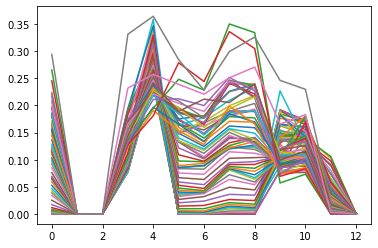

In [44]:
reconstructed, _, _ = ae(train_dataset[0:1])
print(reconstructed.shape, train_dataset[0:1].shape)
plt.plot(reconstructed[0].detach().numpy())

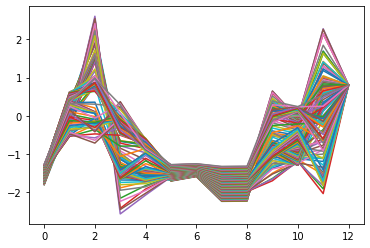

In [45]:
plt.plot(train_dataset[0].detach().numpy())

In [46]:
def reconstruction_loss(generated, original, mode='mean'):
    if mode == 'mean':
        return np.mean((generated.detach().numpy() - original.detach().numpy())**2, axis=(2))
    elif mode == 'max':
        return np.max((generated.detach().numpy() - original.detach().numpy())**2, axis=(2))

In [47]:
reconstructed,_,_ = ae(train_dataset[:])
reconstruction_error = reconstruction_loss(reconstructed, train_dataset[:])

In [57]:
faulty_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33D3/7hnz0038.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

In [58]:
reconstructed,_,_ = ae(faulty_dataset[:])
abnormal_reconstruction_error = reconstruction_loss(reconstructed, faulty_dataset[:])

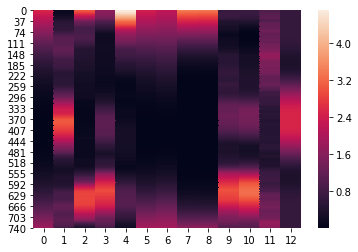

In [62]:
sns.heatmap(abnormal_reconstruction_error)


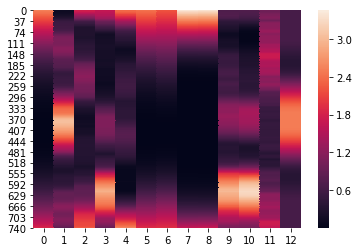

In [63]:
sns.heatmap(reconstruction_error)

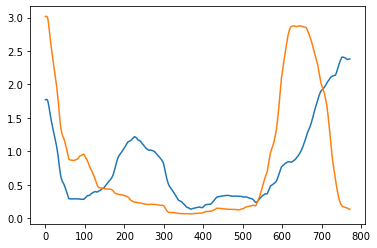

In [61]:
plt.plot(reconstruction_error[:,2])
plt.plot(abnormal_reconstruction_error[:,2])

In [40]:
ae


AE(
  (encoder): Encoder(
    (conv1): Conv1d(13, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (layers): ModuleList(
      (0): Conv1d(128, 64, kernel_size=(3,), stride=(2,), padding=(2,), dilation=(2,))
      (1): Conv1d(64, 32, kernel_size=(3,), stride=(2,), padding=(4,), dilation=(4,))
      (2): Conv1d(32, 16, kernel_size=(3,), stride=(2,), padding=(8,), dilation=(8,))
      (3): Conv1d(16, 8, kernel_size=(3,), stride=(2,), padding=(16,), dilation=(16,))
      (4): Conv1d(8, 4, kernel_size=(3,), stride=(2,), padding=(32,), dilation=(32,))
    )
    (activation): ReLU()
    (mean): Linear(in_features=16, out_features=16, bias=True)
    (std): Linear(in_features=16, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): ConvTranspose1d(4, 8, kernel_size=(4,), stride=(1,))
      (1): ConvTranspose1d(8, 16, kernel_size=(8,), stride=(1,))
      (2): ConvTranspose1d(16, 32, kernel_size=(16,), stride=(1,))
      (3): ConvTranspose1d(32, 64, ker